# Table of contents
1. [Fine tune tuberculosis detector on data without augmentation](#no_augmentation)
    1. [Train classifier with different parameters' values](#try_hyperparams_no_augmentation)
    2. [Select best hyperparameters' values based on validation accuracy](#select_hyperparams_no_augmentation)
    3. [Get test accuracy of the best model](#test_accuracy_no_augmentation)
2. [Train tuberculosis detector on data with basic augmentation](#no_augmentation)
3. [Train tuberculosis detector on data with augmented with GAN](#no_augmentation)


# Fine tune tuberculosis detector on real data without augmentation<a name='no_augmentation'></a>

## Train classifier with different parameters' values<a name='try_hyperparams_no_augmentation'></a>

In [1]:
%matplotlib inline
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, BatchNormalization, GlobalAveragePooling2D, Dropout, Dense, LeakyReLU
from tensorflow.keras import Model
from itertools import product
from math import ceil

In [2]:
# Normalize [-1, 1] input images
def normalize(img):
    img = img / 127.5 - 1
    return img


def denormalize(img):
    img = (img+1)*127.5
    return img.astype(np.uint8)

In [3]:
trainDir = '../xrays_256/train'
validDir = '../xrays_256/validate'

IMG_SIZE = 128
BATCH_SIZE = 16
image_generator = ImageDataGenerator(preprocessing_function=normalize)

flow_args = {
    'target_size': (IMG_SIZE, IMG_SIZE),
    'color_mode': 'rgb',
    'batch_size': BATCH_SIZE,
    'class_mode': 'categorical',
    'shuffle': True,
    'seed': 1
}

train_generator = image_generator.flow_from_directory(
    directory=trainDir,
    **flow_args
)

validation_generator = image_generator.flow_from_directory(
    directory=validDir,
    **flow_args
)

Found 1002 images belonging to 4 classes.
Found 79 images belonging to 2 classes.


IndexError: tuple index out of range

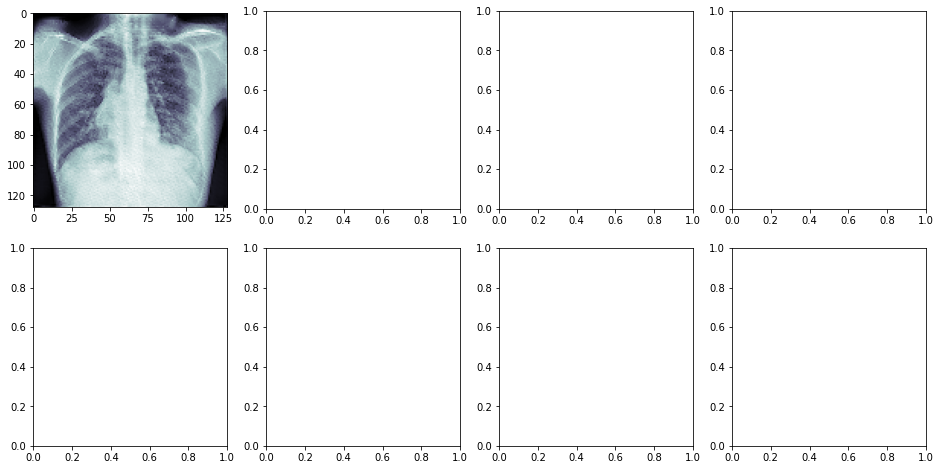

In [4]:
import matplotlib.pyplot as plt

label_to_name = (
    'Healthy',
    'Pulmonary Abnormality'
)

images, labels = next(train_generator)
fig, ax = plt.subplots(2, 4, figsize=(16, 8))
for i, l, a in zip(images, labels, ax.flatten()):
    a.imshow(denormalize(i[:, :, 0]), cmap='bone')
    a.set_title(label_to_name[np.argmax(l)])
    a.axis('off')

Model is based on https://github.com/zeeshannisar/Transfer-Learning-and-Fine-Tuning-with-Pre-Trained-Networks/blob/master/Transfer%20Learning%20with%20VGG16/Fine%20tuning%20with%20Pretrained%20VGG16%20for%20Tuberculosis%20Classification.ipynb

In [5]:
from tensorflow.keras.applications.vgg16 import VGG16

CLASS_COUNT = 2 # normal and abnormal

In [6]:
def get_model(optimizer, learning_rate, dropout_rate, units):
    img_shape = (IMG_SIZE, IMG_SIZE, 3)
    vgg16_model = VGG16(input_shape=img_shape,
                        include_top=False, weights='imagenet')
    vgg16_model.trainable = False

    inputs = Input(img_shape)
    outputs = vgg16_model(inputs)
    outputs = BatchNormalization(name='BatchNormalization')(outputs)
    outputs = GlobalAveragePooling2D()(outputs)
    outputs = Dropout(dropout_rate)(outputs)
    outputs = Dense(units)(outputs)
    outputs = LeakyReLU(alpha=0.1)(outputs)
    outputs = Dropout(dropout_rate)(outputs)
    outputs = Dense(CLASS_COUNT, activation='sigmoid')(outputs)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(
        optimizer(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.FalsePositives(),
            tf.keras.metrics.FalseNegatives()
        ]
    )

    model.summary()
    return model

In [7]:
TRAIN_COUNT = train_generator.samples
VALIDATION_COUNT = validation_generator.samples
TUNE_EPOCHS = 100

In [8]:
HYPERPARAMETERS = {
    'optimizer': [tf.keras.optimizers.Adam],
    'learning_rate': [1e-4, 2e-4, 3e-4],
    'dropout_rate': [i/10 for i in range(3, 6)],
    'units': [256]
}

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

def get_callbacks(idx):
    checkpoint_callback = ModelCheckpoint(
        f'checkpoint/{idx}/100',
        monitor='val_accuracy',
        verbose=1,
        mode='max',
        save_best_only=True
    )
    stop_callback = EarlyStopping(monitor='val_accuracy', mode='max', patience=15)
    board_callback = TensorBoard(log_dir=f'logs/{idx}')
    
    return checkpoint_callback, stop_callback, board_callback

In [ ]:
for i, hp in enumerate(product(*HYPERPARAMETERS.values())):
    print('Evaluate hyperparameters values:')
    for p, v in zip((k for k in HYPERPARAMETERS), hp):
        print(f'{p}: {v}')

    model = get_model(*hp)
    
    model.fit(
        train_generator,
        steps_per_epoch=ceil(TRAIN_COUNT/BATCH_SIZE),
        validation_data=validation_generator,
        validation_steps=ceil(VALIDATION_COUNT/BATCH_SIZE),
        epochs=TUNE_EPOCHS,
        callbacks=get_callbacks(i)
    )

Evaluate hyperparameters values:
optimizer: <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>
learning_rate: 0.0001
dropout_rate: 0.3
units: 256
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
BatchNormalization (BatchNor (None, 4, 4, 512)         2048      
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256

Epoch 1/100
41/41 [==============================] - 8s 182ms/step - loss: 0.6537 - accuracy: 0.6667 - false_positives_1: 145.0000 - false_negatives_1: 356.0000 - val_loss: 0.6404 - val_accuracy: 0.5190 - val_false_positives_1: 31.0000 - val_false_negatives_1: 39.0000

Epoch 00001: val_accuracy improved from -inf to 0.51899, saving model to checkpoint/1/100
INFO:tensorflow:Assets written to: checkpoint/1/100/assets
Epoch 2/100
41/41 [==============================] - 6s 155ms/step - loss: 0.6032 - accuracy: 0.7227 - false_positives_1: 153.0000 - false_negatives_1: 233.0000 - val_loss: 0.5884 - val_accuracy: 0.7848 - val_false_positives_1: 14.0000 - val_false_negatives_1: 22.0000

Epoch 00002: val_accuracy improved from 0.51899 to 0.78481, saving model to checkpoint/1/100
INFO:tensorflow:Assets written to: checkpoint/1/100/assets
Epoch 3/100
41/41 [==============================] - 7s 168ms/step - loss: 0.5612 - accuracy: 0.7492 - false_positives_1: 147.0000 - false_negatives_1: 203.000


Epoch 00024: val_accuracy did not improve from 0.89873
Epoch 25/100
41/41 [==============================] - 6s 157ms/step - loss: 0.4040 - accuracy: 0.8411 - false_positives_1: 104.0000 - false_negatives_1: 107.0000 - val_loss: 0.3386 - val_accuracy: 0.8987 - val_false_positives_1: 8.0000 - val_false_negatives_1: 8.0000

Epoch 00025: val_accuracy did not improve from 0.89873
Epoch 26/100
41/41 [==============================] - 6s 157ms/step - loss: 0.3938 - accuracy: 0.8411 - false_positives_1: 104.0000 - false_negatives_1: 109.0000 - val_loss: 0.3361 - val_accuracy: 0.8987 - val_false_positives_1: 8.0000 - val_false_negatives_1: 8.0000

Epoch 00026: val_accuracy did not improve from 0.89873
Epoch 27/100
41/41 [==============================] - 6s 150ms/step - loss: 0.3908 - accuracy: 0.8411 - false_positives_1: 99.0000 - false_negatives_1: 111.0000 - val_loss: 0.3349 - val_accuracy: 0.8987 - val_false_positives_1: 8.0000 - val_false_negatives_1: 8.0000

Epoch 00027: val_accuracy di

41/41 [==============================] - 7s 159ms/step - loss: 0.4945 - accuracy: 0.7928 - false_positives_2: 150.0000 - false_negatives_2: 135.0000 - val_loss: 0.3929 - val_accuracy: 0.8861 - val_false_positives_2: 9.0000 - val_false_negatives_2: 10.0000

Epoch 00010: val_accuracy did not improve from 0.89873
Epoch 11/100
41/41 [==============================] - 7s 163ms/step - loss: 0.4701 - accuracy: 0.8053 - false_positives_2: 133.0000 - false_negatives_2: 136.0000 - val_loss: 0.3831 - val_accuracy: 0.8861 - val_false_positives_2: 9.0000 - val_false_negatives_2: 10.0000

Epoch 00011: val_accuracy did not improve from 0.89873
Epoch 12/100
41/41 [==============================] - 6s 158ms/step - loss: 0.4842 - accuracy: 0.7975 - false_positives_2: 130.0000 - false_negatives_2: 142.0000 - val_loss: 0.3761 - val_accuracy: 0.8861 - val_false_positives_2: 9.0000 - val_false_negatives_2: 10.0000

Epoch 00012: val_accuracy did not improve from 0.89873
Epoch 13/100
41/41 [==================


Epoch 00007: val_accuracy did not improve from 0.89873
Epoch 8/100
41/41 [==============================] - 3s 73ms/step - loss: 0.4134 - accuracy: 0.8396 - false_positives_3: 109.0000 - false_negatives_3: 105.0000 - val_loss: 0.3657 - val_accuracy: 0.8987 - val_false_positives_3: 8.0000 - val_false_negatives_3: 8.0000

Epoch 00008: val_accuracy did not improve from 0.89873
Epoch 9/100
41/41 [==============================] - 3s 74ms/step - loss: 0.4055 - accuracy: 0.8458 - false_positives_3: 104.0000 - false_negatives_3: 106.0000 - val_loss: 0.3561 - val_accuracy: 0.8987 - val_false_positives_3: 8.0000 - val_false_negatives_3: 8.0000

Epoch 00009: val_accuracy did not improve from 0.89873
Epoch 10/100
41/41 [==============================] - 3s 74ms/step - loss: 0.4053 - accuracy: 0.8474 - false_positives_3: 106.0000 - false_negatives_3: 100.0000 - val_loss: 0.3518 - val_accuracy: 0.8987 - val_false_positives_3: 8.0000 - val_false_negatives_3: 9.0000

Epoch 00010: val_accuracy did no

In [11]:
%load_ext tensorboard
%tensorboard --logdir logs/1

## Select best hyperparameters values based on validation accuracy<a name='select_hyperparams_no_augmentation'></a>

In [24]:
# best_accuracy, best_idx = 0.0, 0
# best_hyperparameters = ()

metric_list = []
for i, hp in enumerate(product(*HYPERPARAMETERS.values())):
    print('Evaluate hyperparameters values:')
    for p, v in zip((k for k in HYPERPARAMETERS), hp):
        print(f'{p}: {v}')

    model = tf.keras.models.load_model(f'checkpoint/{i}/100')

    metrics = model.evaluate(
        validation_generator,
        steps=ceil(VALIDATION_COUNT/BATCH_SIZE),
        return_dict=True
    )
    accuracy = metrics['accuracy']
    false_positives = metrics[
        'false_positives{}'
        .format('' if i == 0 else f'_{i}')
    ]
    false_negatives = metrics[
        'false_negatives{}'
        .format('' if i == 0 else f'_{i}')
    ]

    metric_list.append((accuracy, false_positives, false_negatives, i, hp))

metric_list = sorted(metric_list, key=lambda m: m[0]-m[1]-m[2])
best_hyperparameters = metric_list[-1][-1]
best_idx = metric_list[-1][-2]
best_accuracy = metric_list[-1][0]

print()
print('Best hyperparameters are:')
for hp, v in zip((k for k in HYPERPARAMETERS), best_hyperparameters):
    print(f'{hp}: {v}')
print(f'Hyperparameters index is {best_idx}')
print(f'Best validation accuracy: {best_accuracy:.2f}')

print('Hyperparameters in ascending order:')

for r in metric_list:
    for p, v in zip((k for k in HYPERPARAMETERS), r[-1]):
        print(f'{p}: {v}')
    print(f'Validation accuracy: {r[0]:.2f}')
    print(f'False positives: {r[1]:.2f}')
    print(f'False negatives: {r[2]:.2f}')
    print()

Evaluate hyperparameters values:
optimizer: <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>
learning_rate: 0.0001
dropout_rate: 0.3
units: 256
5/5 [==============================] - 1s 120ms/step - loss: 0.3381 - accuracy: 0.8987 - false_positives: 9.0000 - false_negatives: 9.0000
Evaluate hyperparameters values:
optimizer: <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>
learning_rate: 0.0001
dropout_rate: 0.4
units: 256
5/5 [==============================] - 1s 118ms/step - loss: 0.3375 - accuracy: 0.8987 - false_positives_1: 8.0000 - false_negatives_1: 9.0000
Evaluate hyperparameters values:
optimizer: <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>
learning_rate: 0.0001
dropout_rate: 0.5
units: 256
5/5 [==============================] - 1s 122ms/step - loss: 0.4607 - accuracy: 0.8861 - false_positives_2: 9.0000 - false_negatives_2: 11.0000
Evaluate hyperparameters values:
optimizer: <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>
learning_rate: 0.

## Get test accuracy of the best model<a name='test_accuracy_no_augmentation'></a>

In [24]:
TEST_COUNT = test_generator.samples

In [22]:
testDir = '../xrays_256/test'

test_generator = image_generator.flow_from_directory(
    directory=testDir,
    **flow_args
)

Found 79 images belonging to 2 classes.


In [33]:
print('Evaluate model with best hyperparameters on test data:')
for hp, v in zip((k for k in HYPERPARAMETERS), best_hyperparameters):
    print(f'{hp}: {v}')

model = tf.keras.models.load_model(f'checkpoint/{best_idx}/100')
metrics = model.evaluate(
    test_generator,
    steps=ceil(TEST_COUNT/BATCH_SIZE),
    return_dict=True
)
accuracy = metrics['accuracy']
false_positives = metrics[f'false_positives_{best_idx}']
false_negatives = metrics[f'false_negatives_{best_idx}']

print(f'Accuracy on test data: {accuracy:.2f}')
print(f'False positives: {false_positives:.2f}')
print(f'False negatives: {false_negatives:.2f}')

Evaluate model with best hyperparameters on test data:
optimizer: <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>
learning_rate: 0.0003
dropout_rate: 0.3
units: 256
5/5 [==============================] - 1s 70ms/step - loss: 0.5113 - accuracy: 0.7595 - false_positives_6: 17.0000 - false_negatives_6: 20.0000
Accuracy on test data: 0.76
False positives: 17.00
False negatives: 20.00


## Train tuberculosis detector on data augmented with FastGAN

In [15]:
trainDir = '../xrays_256/train_fastgan'
validDir = '../xrays_256/validate'

IMG_SIZE = 128
BATCH_SIZE = 16
image_generator = ImageDataGenerator(preprocessing_function=normalize)

flow_args = {
    'target_size': (IMG_SIZE, IMG_SIZE),
    'color_mode': 'rgb',
    'batch_size': BATCH_SIZE,
    'class_mode': 'categorical',
    'shuffle': True,
    'seed': 1
}

train_generator = image_generator.flow_from_directory(
    directory=trainDir,
    **flow_args
)

validation_generator = image_generator.flow_from_directory(
    directory=validDir,
    **flow_args
)

Found 1002 images belonging to 2 classes.
Found 79 images belonging to 2 classes.


In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

def get_callbacks(idx):
    checkpoint_callback = ModelCheckpoint(
        f'checkpoint/fastgan',
        monitor='val_accuracy',
        verbose=1,
        mode='max',
        save_best_only=True
    )
    board_callback = TensorBoard(log_dir=f'logs/fastgan')
    
    return checkpoint_callback, board_callback

In [17]:
TRAIN_COUNT = train_generator.samples

In [18]:
model = get_model(tf.keras.optimizers.Adam, 3e-4, 0.3, 256)

model.fit(
    train_generator,
    steps_per_epoch=ceil(TRAIN_COUNT/BATCH_SIZE),
    validation_data=validation_generator,
    validation_steps=ceil(VALIDATION_COUNT/BATCH_SIZE),
    epochs=TUNE_EPOCHS,
    callbacks=get_callbacks(i)
)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
BatchNormalization (BatchNor (None, 4, 4, 512)         2048      
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0   


Epoch 00020: val_accuracy did not improve from 0.89873
Epoch 21/100
63/63 [==============================] - 9s 138ms/step - loss: 0.1746 - accuracy: 0.9281 - false_positives_1: 69.0000 - false_negatives_1: 70.0000 - val_loss: 0.3457 - val_accuracy: 0.8861 - val_false_positives_1: 9.0000 - val_false_negatives_1: 10.0000

Epoch 00021: val_accuracy did not improve from 0.89873
Epoch 22/100
63/63 [==============================] - 9s 135ms/step - loss: 0.1922 - accuracy: 0.9142 - false_positives_1: 86.0000 - false_negatives_1: 86.0000 - val_loss: 0.3443 - val_accuracy: 0.8734 - val_false_positives_1: 10.0000 - val_false_negatives_1: 10.0000

Epoch 00022: val_accuracy did not improve from 0.89873
Epoch 23/100
63/63 [==============================] - 9s 142ms/step - loss: 0.1825 - accuracy: 0.9271 - false_positives_1: 77.0000 - false_negatives_1: 71.0000 - val_loss: 0.3468 - val_accuracy: 0.8734 - val_false_positives_1: 9.0000 - val_false_negatives_1: 10.0000

Epoch 00023: val_accuracy did

63/63 [==============================] - 10s 164ms/step - loss: 0.0864 - accuracy: 0.9731 - false_positives_1: 32.0000 - false_negatives_1: 29.0000 - val_loss: 0.4296 - val_accuracy: 0.8354 - val_false_positives_1: 13.0000 - val_false_negatives_1: 14.0000

Epoch 00071: val_accuracy did not improve from 0.89873
Epoch 72/100
63/63 [==============================] - 10s 166ms/step - loss: 0.0712 - accuracy: 0.9780 - false_positives_1: 24.0000 - false_negatives_1: 26.0000 - val_loss: 0.4370 - val_accuracy: 0.8101 - val_false_positives_1: 15.0000 - val_false_negatives_1: 14.0000

Epoch 00072: val_accuracy did not improve from 0.89873
Epoch 73/100
63/63 [==============================] - 11s 167ms/step - loss: 0.0640 - accuracy: 0.9800 - false_positives_1: 19.0000 - false_negatives_1: 20.0000 - val_loss: 0.4652 - val_accuracy: 0.8101 - val_false_positives_1: 15.0000 - val_false_negatives_1: 15.0000

Epoch 00073: val_accuracy did not improve from 0.89873
Epoch 74/100
63/63 [==================

In [19]:
%load_ext tensorboard
%tensorboard --logdir logs/fastgan

## Test model augmented with FastGAN

In [27]:
print('Evaluate model with best hyperparameters on test data:')
for hp, v in zip((k for k in HYPERPARAMETERS), (tf.keras.optimizers.Adam, 3e-4, 0.3, 256)):
    print(f'{hp}: {v}')

model = tf.keras.models.load_model(f'checkpoint/fastgan')
metrics = model.evaluate(
    test_generator,
    steps=ceil(TEST_COUNT/BATCH_SIZE),
    return_dict=True
)
accuracy = metrics['accuracy']
false_positives = metrics[f'false_positives_1']
false_negatives = metrics[f'false_negatives_1']

print(f'Accuracy on test data: {accuracy:.2f}')
print(f'False positives: {false_positives:.2f}')
print(f'False negatives: {false_negatives:.2f}')

Evaluate model with best hyperparameters on test data:
optimizer: <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>
learning_rate: 0.0003
dropout_rate: 0.3
units: 256
5/5 [==============================] - 1s 109ms/step - loss: 0.5104 - accuracy: 0.7975 - false_positives_1: 18.0000 - false_negatives_1: 19.0000
Accuracy on test data: 0.80
False positives: 18.00
False negatives: 19.00
